# Under -/Oversample Media and Products Datasets and Combine Labels for Multi-label Classification

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter
import time
import math
import random

BASE_DIR = "../"
DATA_DIR = "data"
MEDIA_FILE = "imbalanced_media.csv"
PRODUCTS_FILE = "imbalanced_products.csv"

media_path = os.path.join(BASE_DIR, DATA_DIR, MEDIA_FILE)
products_path = os.path.join(BASE_DIR, DATA_DIR, PRODUCTS_FILE)

media = pd.read_csv(media_path)
products = pd.read_csv(products_path)

In [2]:
media.fillna(value = {'media_caption': 'no caption'}, inplace = True)

# Place the products into different classes
## Products -> Main Category -> Sub Category -> Product Category

In [3]:
#Put products into different bins based on product attributes.
#Products -> Main Category -> Sub Category -> Product Category
productID_classID = {}
className_classID = {} # index each class
className_productID = defaultdict(list) # store the productIDs in corresponding classes
curr_num_classes = 0

# map productID to class ID
for idx, row_data in products.iterrows():
    class_name = ':'.join([row_data.main_category, row_data.sub_category, 
                           row_data.product_category])
    if class_name not in className_classID:
        className_classID[class_name] = curr_num_classes
        curr_num_classes += 1
    
    product_ID, classID = row_data.loc['product_id'], className_classID[class_name]
    productID_classID[product_ID] = classID
    className_productID[class_name].append(product_ID)
    
#reverse mapping, class ID -> class name
classID_className = {value: key for key, value in className_classID.items()}

In [26]:
print(classID_className)

{0: 'color cosmetics:eye:eyebrow', 1: 'skincare:skincare:moisturizer', 2: 'color cosmetics:eye:eyeshadow', 3: 'color cosmetics:eye:mascara', 4: 'accessories:accessories:brush', 5: 'fragrance:fragrance:fragrance', 6: 'skincare:skincare:cleanser', 7: 'accessories:accessories:tool', 8: 'nail:nail:nail polish', 9: 'color cosmetics:eye:eye palette', 10: 'bath body:bath body:wash', 11: 'hair:style:styling products', 12: 'skincare:skincare:treatments', 13: 'color cosmetics:face:powder', 14: 'skincare:skincare:mask', 15: 'bath body:bath body:body lotion', 16: 'hair:cleanse:conditioner', 17: 'color cosmetics:cheek:cheek palette', 18: 'color cosmetics:lip:lipstick', 19: 'hair:treat:hair treatments', 20: 'color cosmetics:cheek:highlighter', 21: 'hair:cleanse:shampoo', 22: 'color cosmetics:face:setting spray', 23: 'color cosmetics:cheek:blush', 24: 'skincare:skincare:face suncare', 25: 'color cosmetics:eye:eyeliner', 26: 'color cosmetics:face:face palette', 27: 'color cosmetics:face:foundation', 2

## Add another column in media data frame, for fine cagegories

In [4]:
media.drop('class_ID', axis=1, inplace=True)
labels = []
for idx, row_data in media.iterrows():
    productID = row_data.tagged_product_id
    classID = productID_classID[productID]
    labels.append(classID)
media['label'] = labels

## Drop duplicate rows

In [5]:
old_len = len(media)
columns_to_consider = list(set(media.columns) - set(['tagged_product_id']))
media.drop_duplicates(subset=columns_to_consider, keep='first', inplace=True)
new_len = len(media)
print("The length of media datafram before and after dropping duplicate rows are %d and %d." %(old_len, new_len))

The length of media datafram before and after dropping duplicate rows are 213390 and 190167.


## convert int labels to list, for ease of combining multi-labels of same media

In [6]:
labels = []
for idx, row_data in media.iterrows():    
    label = row_data.label
    labels.append([label])
media['label'] = labels

## Show the imbalance of current datasets

In [7]:
def plot_distribution(media, classID_className):
    classID_numMentions = defaultdict(int)
    for idx, row_data in media.iterrows():
        for classID in row_data.label:
            classID_numMentions[classID] += 1
        
    classID_mentions = [[key, val] for key, val in classID_numMentions.items()]
    classID_mentions.sort(key = lambda x : x[1], reverse = True)

    #distribution = [i for i in classID_mentions if i[1] > 1131]
    distribution = [i for i in classID_mentions]

    print(len(distribution))
    #med_num = np.median(np.array([i[1] for i in distribution]))
    #print("median of number of products in each product category is: %d" %med_num)
    class_names = [classID_className[i[0]].split(':')[2] for i in distribution]
    sns.set(font_scale = 1.8)
    plt.figure(figsize=(15,8))
    ax= sns.barplot(class_names, [i[1] for i in distribution])
    for item in ax.get_xticklabels():
        item.set_rotation(90)
    plt.title("distribution of media posts", fontsize=24)
    plt.ylabel('number of media posts', fontsize=26)
    plt.xlabel('product type', fontsize=26)

    #add the text labels for max and min numbers
    rects = [ax.patches[0], ax.patches[-1]]
    labels = [distribution[0][1], distribution[-1][1]]
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2, height + 10, label, ha='center', va='bottom', fontsize=22)
    return distribution

40


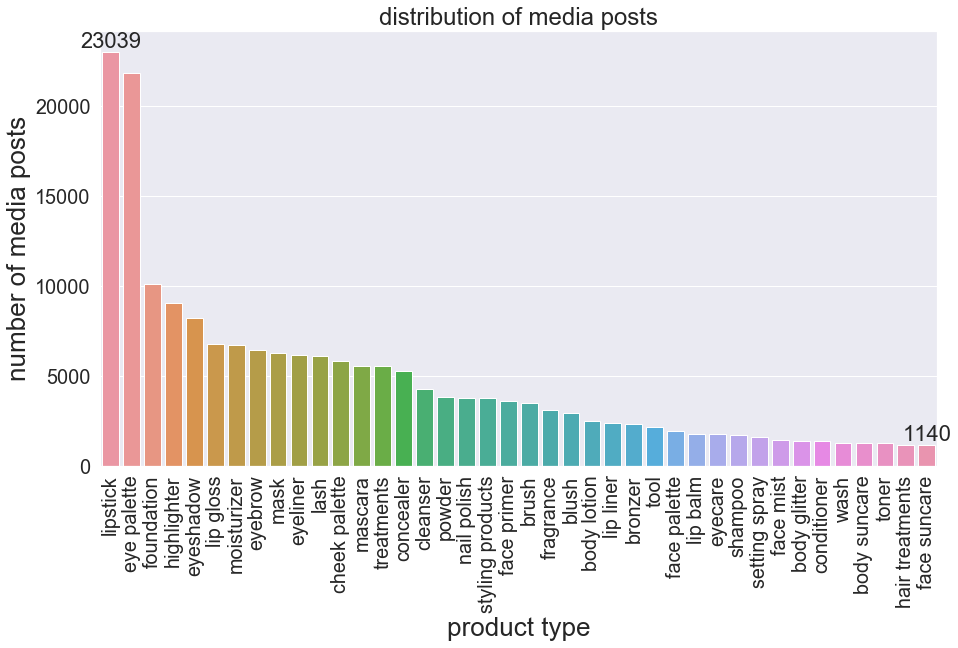

In [8]:
distribution = plot_distribution(media, classID_className)

In [9]:
# classIDs to under-/over-sample
classIDs_to_underSample = [i[0] for i in distribution[:10]]
classIDs_to_overSample = [i[0] for i in distribution[-16:]]

In [10]:
print(classIDs_to_underSample)
print(classIDs_to_overSample)

[18, 9, 27, 20, 2, 32, 1, 0, 14, 25]
[37, 35, 7, 26, 28, 30, 21, 22, 29, 39, 16, 10, 38, 36, 19, 24]


## Add two additional columns before combining, to speed up re-sampling process

In [11]:
under_sample, over_sample = [], []
for idx, row_data in media.iterrows():
    classID = row_data.label[0]
    under = 1 if classID in classIDs_to_underSample else 0
    under_sample.append(under)
    over = 1 if (classID in classIDs_to_overSample and under == 0) else 0
    over_sample.append(over)
    
media['under_sample'] = under_sample
media['over_sample'] = over_sample

## Combine meida dataframe based on media_id for multi-class, multi-labels training

In [12]:
aggregation_functions = {column:'first' for column in media.columns}
aggregation_functions['label'] = 'sum'
aggregation_functions['under_sample'] = 'max'
aggregation_functions['over_sample'] = 'max'

media = media.groupby(media['media_id'], as_index=False).aggregate(aggregation_functions)

## Test if there are duplicates in labels

In [13]:
for idx, row_data in media.iterrows():
    labels = row_data.label
    old_len = len(labels)
    new_len = len(list(set(labels)))
    if old_len != new_len:
        print('warning')

In [14]:
aa=media[media.under_sample == 1]
aa=aa[aa.over_sample == 1]
print(len(aa))

8060


## Re-sampling

In [15]:
def under_over_sample(orig_media, under_sample_ratio = 0.2, over_sample_ratio = 3.2): 
    #media = pd.DataFrame()
    
    media = orig_media[orig_media.under_sample == 0]
    media = media[media.over_sample == 0]  
    
    both = orig_media[orig_media.under_sample == 1]
    both = both[both.over_sample == 1]
    
    media = media.append(both)
    
    underSample_instances = orig_media[orig_media.under_sample == 1]
    underSample_instances = underSample_instances[underSample_instances.over_sample == 0]
    # overSample == 1 and underSample == 0
    overSample_instances = orig_media[orig_media.over_sample == 1]
    overSample_instances = overSample_instances[overSample_instances.under_sample == 0]
    
    underSampled = underSample_instances.sample(frac=under_sample_ratio, axis=0, random_state=42)
    overSampled = overSample_instances.sample(frac=over_sample_ratio, axis=0, random_state=42, replace=True)
    #overSampled = overSample_instances
    media = media.append(underSampled)
    media = media.append(overSampled)

    
#    orig_length = len(orig_media)
#    for idx, row_data in orig_media.iterrows():
#        if idx % 5000 == 0:
#            print("%d of %d" %(idx, orig_length))
#           
#        if row_data.under_sample:
#            randNum = random.random()
#            if row_data.
#            if randNum < under_sample_ratio:
#                media = media.append(row_data)
#        elif row_data.over_sample:
#            media = media.append(row_data)
#            media = media.append(row_data)
#        else:
#            media = media.append(row_data)
#                    
    return media

101915
<class 'pandas.core.frame.DataFrame'>
Int64Index: 101915 entries, 0 to 49562
Data columns (total 14 columns):
media_id                     101915 non-null int64
poster_instagram_username    101915 non-null object
poster_account_type          101915 non-null object
media_shortcode              101915 non-null object
media_image_url              101915 non-null object
media_caption                101915 non-null object
num_likes                    101915 non-null int64
num_comments                 101915 non-null int64
media_type                   101915 non-null object
caption_type                 101915 non-null object
tagged_product_id            101915 non-null int64
label                        101915 non-null object
under_sample                 101915 non-null int64
over_sample                  101915 non-null int64
dtypes: int64(6), object(8)
memory usage: 11.7+ MB
40


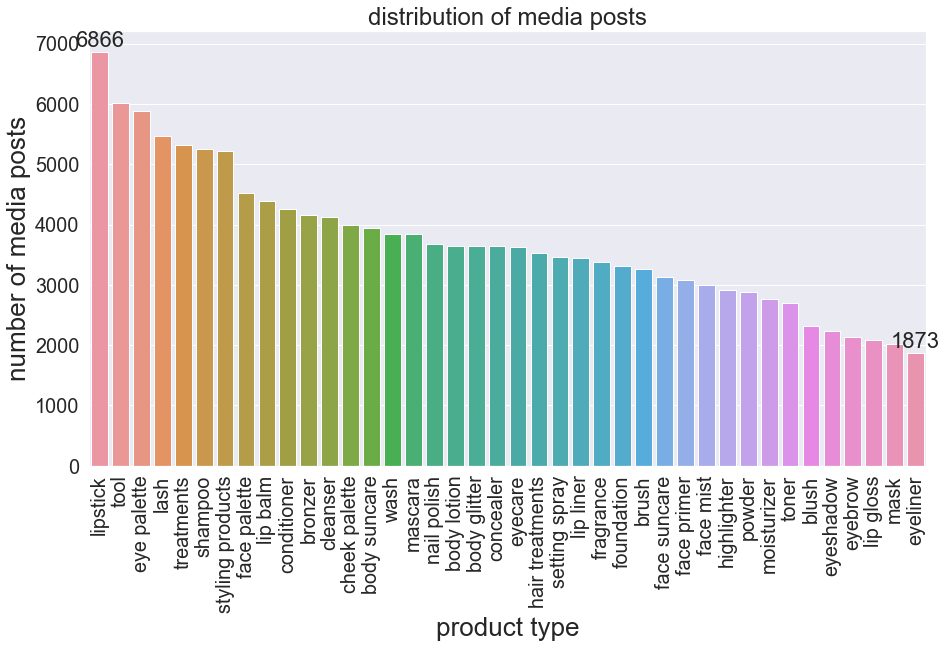

In [16]:
media_sampled = under_over_sample(media)
print(len(media_sampled))
media_sampled.info()
_ = plot_distribution(media_sampled, classID_className)

In [17]:
# need to combine "none" and "shopping_related" into "misc" for caption_time
media_sampled.loc[media_sampled.media_caption == '', 'caption_type'] = 'missing'
media_sampled.loc[media_sampled.caption_type == 'shopping_related', 'caption_type'] = 'misc'
media_sampled.loc[media_sampled.caption_type == 'none', 'caption_type'] = 'misc'

In [18]:
# delete the instance with short code'BpAtcr-AqEU', because image is damaged
media_sampled.drop(media_sampled[media_sampled.media_shortcode == 'BpAtcr-AqEU'].index, 
                   inplace=True)

In [19]:
media_sampled.to_csv(BASE_DIR + "/data/balanced_data.csv", index=False)